In [ ]:
import pickle
from pprint import pprint
import numpy as np
import pandas as pd


with open('WESAD/S2/S2.pkl', 'rb') as file:
    data = pickle.load(file, encoding='latin1')


pprint(data['label'].shape)


(4255300,)


Postgresql Connection

In [ ]:
import psycopg2


connection_params = {
    'dbname': 'postgres',
    'user': '',
    'password': '',
    'host': 'localhost',  # e.g., 'localhost'
    'port': '5432'   # e.g., 5432
}


try:
    conn = psycopg2.connect(**connection_params)
    print("Database connection established!")
except Exception as e:
    print(f"Error connecting to database: {e}")
finally:
    conn.close()


Database connection established!


In [ ]:
import psycopg2
import pandas as pd
import numpy as np
import pickle

# Set up connection parameters
conn = psycopg2.connect(
    dbname="postgres",
    user="",
    password="",
    host="localhost",
    port="5432"
)

cursor = conn.cursor()

# Step 1: Create the table
#    create_table_query = """
#    CREATE TABLE IF NOT EXISTS test_table (
#        id SERIAL PRIMARY KEY,
#        name VARCHAR(50),
#        age INTEGER
#    );
#    """

#    cursor.execute(create_table_query)
#    print("Table 'test_table' created successfully.")

# # Step 2: Insert sample data into the table
# insert_sample_data_query = """
# INSERT INTO test_table (name, age) VALUES
# ('Alice', 25),
# ('Bob', 30),
# ('Charlie', 35)
# ON CONFLICT DO NOTHING;
# """

# cursor.execute(insert_sample_data_query)
# print("Sample data inserted into 'test_table'.")

# # Step 3: Query the table to verify data
# query = "SELECT * FROM test_table;"
# df = pd.read_sql(query, conn)

# conn.commit()

# # Close the cursor and connection
# cursor.close()
# conn.close()

# # Display the results
# print(df)

Data Manipulation

In [ ]:
import psycopg2
import pandas as pd
import numpy as np
import pickle
import os

# Set up connection parameters
conn = psycopg2.connect(
    dbname="postgres",
    user="",
    password="",
    host="localhost",
    port="5432"
)
cursor = conn.cursor()


sampling_rates = {
    "chest": {"ECG": 700, "EMG": 700, "EDA": 700, "Temp": 700, "Resp": 700},
    "wrist": {"BVP": 64, "EDA": 4, "TEMP": 4}
}


ignored_labels = {0, 5, 6, 7}


def aggregate_data(data, rate):
    num_samples = len(data)
    num_windows = num_samples // rate
    reshaped_data = data[:num_windows * rate].reshape(num_windows, rate, -1)
    return reshaped_data.mean(axis=1)


all_subjects_data = []


for subject_id in range(2, 18):
    if subject_id in [1, 12]:  
        continue
    
    subject_name = f"S{subject_id}"
    file_path = os.path.join("WESAD", subject_name, f"{subject_name}.pkl")

    
    with open(file_path, "rb") as file:
        data = pickle.load(file, encoding="latin1")

    
    records = []
    for key, rate in sampling_rates["chest"].items():
        if key in data["signal"]["chest"]:
            avg_data = aggregate_data(np.array(data["signal"]["chest"][key]), rate)
            records.append(pd.DataFrame(avg_data, columns=[f'chest_{key}']))

    
    for key, rate in sampling_rates["wrist"].items():
        if key in data["signal"]["wrist"]:
            avg_data = aggregate_data(np.array(data["signal"]["wrist"][key]), rate)
            records.append(pd.DataFrame(avg_data, columns=[f'wrist_{key}']))

    
    labels = aggregate_data(np.array(data["label"]), 700)  
    records.append(pd.DataFrame(labels, columns=["label"]))

    
    subject_df = pd.concat(records, axis=1)
    subject_df = subject_df[~subject_df["label"].isin(ignored_labels)]
    subject_df["subject"] = subject_name
    all_subjects_data.append(subject_df)


final_df = pd.concat(all_subjects_data, axis=0)


table_name = "wearable_data_final_v1"


columns_definitions = ", ".join([f"{col} REAL" for col in final_df.columns if col != 'subject'])
create_table_query = f"""
CREATE TABLE IF NOT EXISTS {table_name} (
    id SERIAL PRIMARY KEY,
    {columns_definitions},
    subject VARCHAR(10)
);
"""
cursor.execute(create_table_query)
conn.commit()


for _, row in final_df.iterrows():
    insert_query = f"INSERT INTO {table_name} ({', '.join(final_df.columns)}) VALUES ({', '.join(['%s'] * len(final_df.columns))})"
    cursor.execute(insert_query, tuple(row))


conn.commit()


print("Data for all subjects successfully inserted into PostgreSQL.")


Data for all subjects successfully inserted into PostgreSQL.


In [ ]:
import pandas as pd


data = pd.read_csv('wearable_data.csv')


data_info = {
    "head": data.head(),
    "description": data.describe(),
    "info": data.info()
}
data_info


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45076 entries, 0 to 45075
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          45076 non-null  int64  
 1   chest_ecg   45076 non-null  float64
 2   chest_emg   45076 non-null  float64
 3   chest_eda   45076 non-null  float64
 4   chest_temp  45076 non-null  float64
 5   chest_resp  45076 non-null  float64
 6   wrist_bvp   45076 non-null  float64
 7   wrist_eda   45076 non-null  float64
 8   wrist_temp  45076 non-null  float64
 9   label       45076 non-null  float64
 10  subject     45076 non-null  object 
dtypes: float64(9), int64(1), object(1)
memory usage: 3.8+ MB


{'head':    id  chest_ecg  chest_emg  chest_eda  chest_temp  chest_resp  wrist_bvp  \
 0   2   0.022615  -0.002840   5.580099   29.133152   -1.032288 -18.120155   
 1   3  -0.025130  -0.002691   5.496316   29.138432    0.419909  51.961563   
 2   4   0.005718  -0.002774   5.414110   29.145496    1.917140 -48.005157   
 3   5   0.028033  -0.002678   5.371765   29.148165    2.677695  14.090938   
 4   6  -0.041456  -0.002729   5.336524   29.148066    1.207439   6.260469   
 
    wrist_eda  wrist_temp  label subject  
 0   1.599857       35.81    1.0      S2  
 1   1.574550       35.81    1.0      S2  
 2   1.562698       35.83    1.0      S2  
 3   1.536431       35.83    1.0      S2  
 4   1.527141       35.83    1.0      S2  ,
 'description':                  id     chest_ecg     chest_emg     chest_eda    chest_temp  \
 count  45076.000000  45076.000000  45076.000000  45076.000000  45076.000000   
 mean   22557.746273      0.001110     -0.003011      4.608207     33.876672   
 std    

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


data_path = 'wearable_data.csv'  
data = pd.read_csv(data_path)


sensor_features = ['chest_ecg', 'chest_emg', 'chest_eda', 'chest_temp', 'chest_resp',
                   'wrist_bvp', 'wrist_eda', 'wrist_temp']
label_col = 'label'


import os
output_folder = 'visualizations'
os.makedirs(output_folder, exist_ok=True)


for feature in sensor_features:
    plt.figure(figsize=(8, 6))
    sns.histplot(data[feature], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.savefig(os.path.join(output_folder, f'{feature}_distribution.png'))
    plt.close()


correlation_matrix = data[sensor_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Heatmap of Sensor Features')
plt.savefig(os.path.join(output_folder, 'correlation_heatmap.png'))
plt.close()


plt.figure(figsize=(8, 6))
sns.countplot(x=label_col, data=data, palette='viridis')
plt.title('Label Distribution')
plt.xlabel('Emotion Label')
plt.ylabel('Count')
plt.grid(True)
plt.savefig(os.path.join(output_folder, 'label_distribution.png'))
plt.close()


if 'subject' in data.columns:
    example_subject = data[data['subject'] == data['subject'].iloc[0]]
    plt.figure(figsize=(12, 6))
    plt.plot(example_subject['chest_ecg'][:1000], label='Chest ECG', alpha=0.8)
    plt.plot(example_subject['wrist_bvp'][:1000], label='Wrist BVP', alpha=0.8)
    plt.title('Temporal Trends for Subject (First 1000 Samples)')
    plt.xlabel('Time Index')
    plt.ylabel('Sensor Value')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_folder, 'temporal_trends.png'))
    plt.close()

print(f"Visualizations saved in the '{output_folder}' folder.")


Visualizations saved in the 'visualizations' folder.


/var/folders/79/_srhgmyx6_gf32743dw22k3c0000gn/T/ipykernel_67877/4032566993.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=label_col, data=data, palette='viridis')


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X = data.drop(columns=['id', 'subject', 'label'])
y = data['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((36060, 8), (9016, 8), (36060,), (9016,))

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Random Forest Classifier and Gradient Boosting Classifiers 


In [4]:
#Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_classification_report = classification_report(y_test, y_pred_rf)
print("Random Forest Classifier Accuracy:", rf_accuracy)
print("Random Forest Classification Report:\n", rf_classification_report)

#Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
gb_accuracy = accuracy_score(y_test, y_pred_gb)
gb_classification_report = classification_report(y_test, y_pred_gb)
print("Gradient Boosting Classifier Accuracy:", gb_accuracy)
print("Gradient Boosting Classification Report:\n", gb_classification_report)

Random Forest Classifier Accuracy: 0.9947870452528838
Random Forest Classification Report:
               precision    recall  f1-score   support

         1.0       1.00      0.99      1.00      3536
         2.0       1.00      1.00      1.00      2000
         3.0       0.98      1.00      0.99      1120
         4.0       0.99      0.99      0.99      2360

    accuracy                           0.99      9016
   macro avg       0.99      0.99      0.99      9016
weighted avg       0.99      0.99      0.99      9016

Gradient Boosting Classifier Accuracy: 0.9851375332741792
Gradient Boosting Classification Report:
               precision    recall  f1-score   support

         1.0       0.99      0.99      0.99      3536
         2.0       0.99      0.99      0.99      2000
         3.0       0.98      0.97      0.98      1120
         4.0       0.98      0.99      0.98      2360

    accuracy                           0.99      9016
   macro avg       0.98      0.98      0.98    

In [5]:
rf_cm = confusion_matrix(y_test, y_pred_rf)
gb_cm = confusion_matrix(y_test, y_pred_gb)

Text(0, 0.5, 'Accuracy')

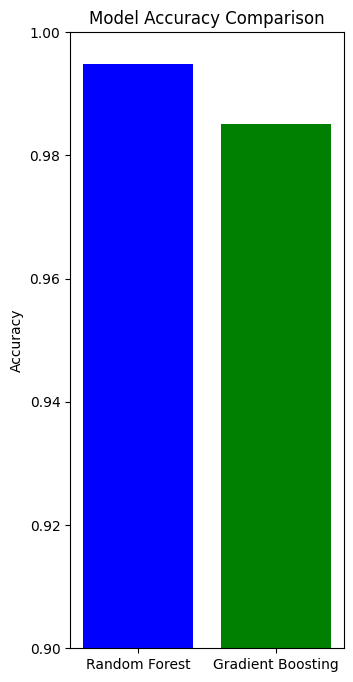

In [6]:
plt.figure(figsize=(12, 8))

# Accuracy 
plt.subplot(1, 3, 1)
plt.bar(['Random Forest', 'Gradient Boosting'], [rf_accuracy, gb_accuracy], color=['blue', 'green'])
plt.ylim(0.9, 1)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')

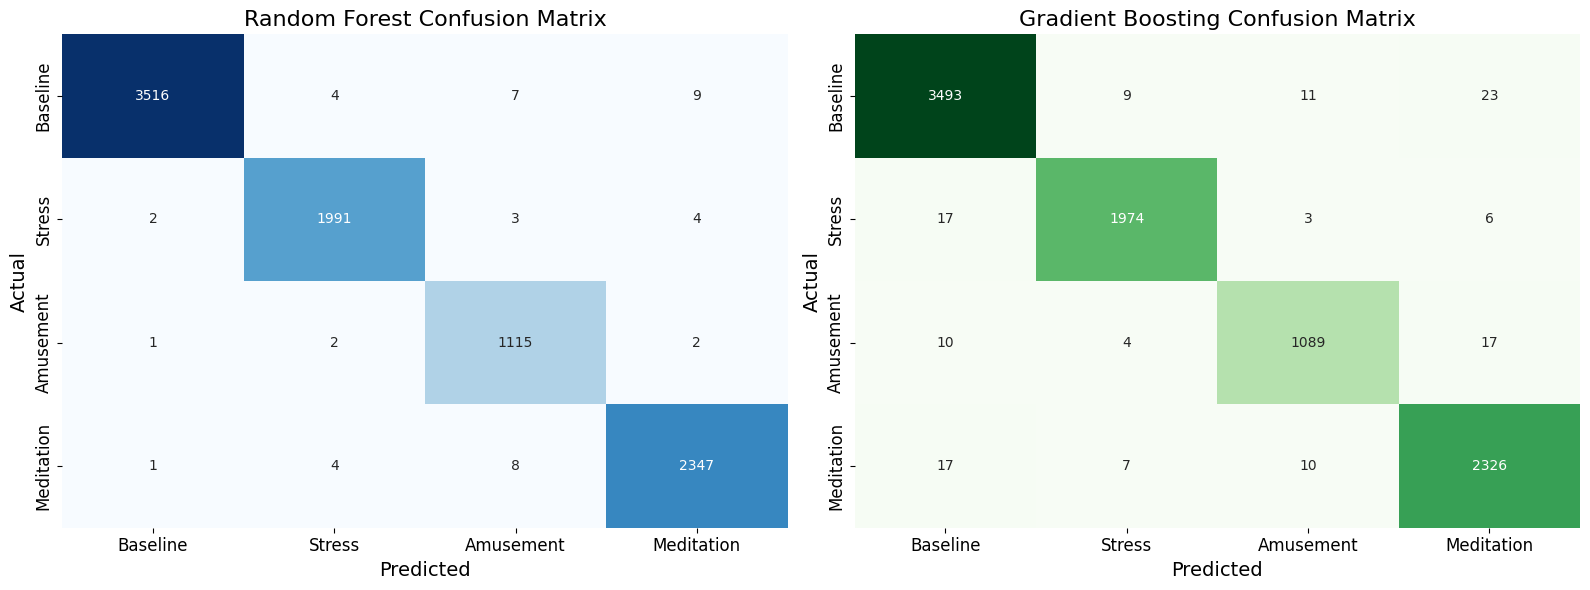

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns


emotions = ['Baseline', 'Stress', 'Amusement', 'Meditation']


plt.figure(figsize=(16, 6))

# Random Forest Confusion Matrix
plt.subplot(1, 2, 1)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions, cbar=False)
plt.title('Random Forest Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Gradient Boosting Confusion Matrix
plt.subplot(1, 2, 2)
sns.heatmap(gb_cm, annot=True, fmt='d', cmap='Greens', xticklabels=emotions, yticklabels=emotions, cbar=False)
plt.title('Gradient Boosting Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.tight_layout()
plt.show()


LSTM ( RNN ) Model 

In [ ]:
import numpy as np


timesteps = 10

#LSTM input
def create_sequences(data, labels, timesteps):
    sequences = []
    sequence_labels = []
    for i in range(len(data) - timesteps + 1):
        
        sequences.append(data[i:i+timesteps])
        sequence_labels.append(labels[i+timesteps-1])  
    return np.array(sequences), np.array(sequence_labels)


X_train_seq, y_train_seq = create_sequences(X_train, y_train.values, timesteps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test.values, timesteps)

X_train_seq.shape, y_train_seq.shape, X_test_seq.shape, y_test_seq.shape


((36051, 10, 8), (36051,), (9007, 10, 8), (9007,))

X_train_seq shape: (36041, 20, 8)
y_train_seq shape: (36041,)
Any NaN in X_train_seq: False
Any Inf in X_train_seq: False
Any NaN in y_train_seq: False
Any Inf in y_train_seq: False
Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


901/901 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4750 - loss: 1.2191 - val_accuracy: 0.6201 - val_loss: 0.9917
Epoch 2/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6481 - loss: 0.9353 - val_accuracy: 0.6937 - val_loss: 0.8184
Epoch 3/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7011 - loss: 0.7959 - val_accuracy: 0.7177 - val_loss: 0.7369
Epoch 4/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7211 - loss: 0.7192 - val_accuracy: 0.7337 - val_loss: 0.6701
Epoch 5/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7434 - loss: 0.6541 - val_accuracy: 0.7539 - val_loss: 0.6248
Epoch 6/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7584 - loss: 0.6184 - val_accuracy: 0.7706 - val_loss: 0.5885
Epoch 7/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7736 - loss: 0.5776 - val_accuracy: 0.7837 - val_loss: 0.5543
Epoch 8/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7898 - loss: 0.5437 - val_accuracy: 0.7950 - val_

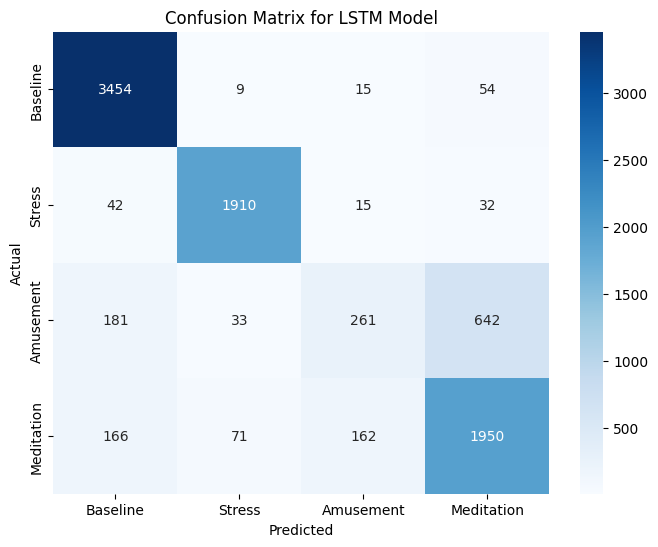

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94      3532
           1       0.94      0.96      0.95      1999
           2       0.58      0.23      0.33      1117
           3       0.73      0.83      0.78      2349

    accuracy                           0.84      8997
   macro avg       0.79      0.75      0.75      8997
weighted avg       0.82      0.84      0.82      8997



In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd


data = pd.read_csv('wearable_data.csv') 
X = data.drop(columns=['id', 'subject', 'label'])
y = data['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


timesteps = 20


def create_sequences(data, labels, timesteps):
    sequences = []
    sequence_labels = []
    for i in range(len(data) - timesteps + 1):
        sequences.append(data[i:i+timesteps])
        sequence_labels.append(labels[i+timesteps-1])
    return np.array(sequences), np.array(sequence_labels)


X_train_seq, y_train_seq = create_sequences(X_train, y_train.values, timesteps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test.values, timesteps)


X_train_seq = X_train_seq.astype('float32')
X_test_seq = X_test_seq.astype('float32')
y_train_seq = y_train_seq.astype('int32')
y_test_seq = y_test_seq.astype('int32')


print("X_train_seq shape:", X_train_seq.shape) 
print("y_train_seq shape:", y_train_seq.shape)  

print("Any NaN in X_train_seq:", np.isnan(X_train_seq).any())
print("Any Inf in X_train_seq:", np.isinf(X_train_seq).any())
print("Any NaN in y_train_seq:", np.isnan(y_train_seq).any())
print("Any Inf in y_train_seq:", np.isinf(y_train_seq).any())

#LSTM model
model = Sequential([
    LSTM(32, input_shape=(timesteps, X_train_seq.shape[2])),
    Dense(4, activation='softmax')
])

y_train_seq -= 1
y_test_seq -= 1


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate
test_loss, test_accuracy = model.evaluate(X_test_seq, y_test_seq)
print(f'Test Accuracy: {test_accuracy}')


y_pred_seq = model.predict(X_test_seq).argmax(axis=1)


conf_matrix = confusion_matrix(y_test_seq, y_pred_seq)
class_names = ['Baseline', 'Stress', 'Amusement', 'Meditation']


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for LSTM Model')
plt.show()


classification_rep = classification_report(y_test_seq, y_pred_seq)
print("Classification Report:\n", classification_rep)


Logistic Regression Model

Accuracy: 0.52
Classification Report:
               precision    recall  f1-score   support

         0.0       0.57      0.79      0.66      3536
         1.0       0.48      0.28      0.35      2000
         2.0       0.00      0.00      0.00      1120
         3.0       0.45      0.56      0.50      2360

    accuracy                           0.52      9016
   macro avg       0.38      0.41      0.38      9016
weighted avg       0.45      0.52      0.47      9016



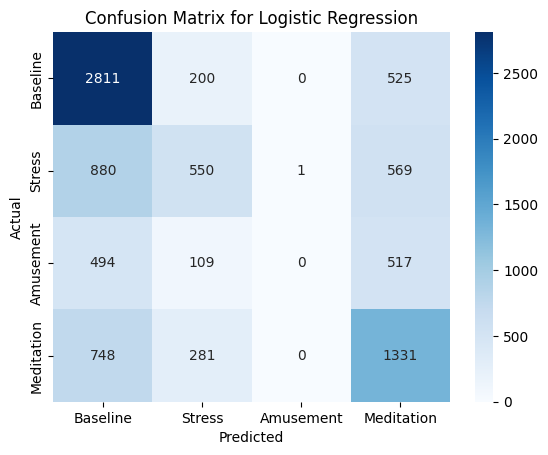

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


data = pd.read_csv('wearable_data.csv')  


X = data.drop(columns=['id', 'subject', 'label'])
y = data['label'] - 1 


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print("Classification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Baseline', 'Stress', 'Amusement', 'Meditation'], 
            yticklabels=['Baseline', 'Stress', 'Amusement', 'Meditation'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()


Support Vector Machine Model

Accuracy: 0.83
Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.97      0.90      3536
         1.0       0.94      0.92      0.93      2000
         2.0       0.75      0.26      0.38      1120
         3.0       0.76      0.81      0.79      2360

    accuracy                           0.83      9016
   macro avg       0.82      0.74      0.75      9016
weighted avg       0.83      0.83      0.81      9016



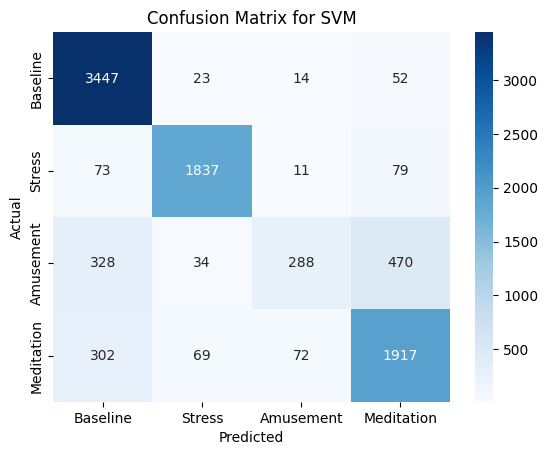

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


data = pd.read_csv('wearable_data.csv')  


X = data.drop(columns=['id', 'subject', 'label'])
y = data['label'] - 1  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize train SVM 
model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)  
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print("Classification Report:\n", classification_report(y_test, y_pred))


conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Baseline', 'Stress', 'Amusement', 'Meditation'], 
            yticklabels=['Baseline', 'Stress', 'Amusement', 'Meditation'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for SVM')
plt.show()


Multi Layer Perceptron Model 

Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


902/902 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step - accuracy: 0.5772 - loss: 1.0588 - val_accuracy: 0.7436 - val_loss: 0.6705
Epoch 2/30
902/902 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - accuracy: 0.7192 - loss: 0.7184 - val_accuracy: 0.8027 - val_loss: 0.4937
Epoch 3/30
902/902 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - accuracy: 0.7760 - loss: 0.5786 - val_accuracy: 0.8412 - val_loss: 0.4206
Epoch 4/30
902/902 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - accuracy: 0.8024 - loss: 0.4941 - val_accuracy: 0.8586 - val_loss: 0.3504
Epoch 5/30
902/902 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - accuracy: 0.8261 - loss: 0.4359 - val_accuracy: 0.8986 - val_loss: 0.2882
Epoch 6/30
902/902 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - accuracy: 0.8424 - loss: 0.3908 - val_accuracy: 0.9161 - val_loss: 0.2510
Epoch 7/30
902/902 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - accuracy: 0.8611 - loss: 0.3631 - val_accuracy: 0.9215 - val_loss: 0.2222
Epoch 8/30
902/902 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - accuracy: 0.8777 - loss: 0.3244 - val_accurac

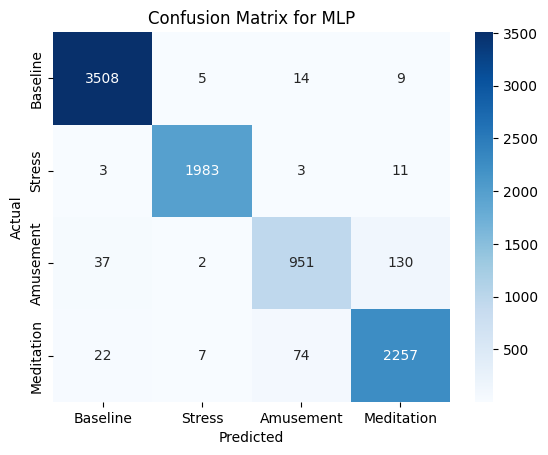

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns


data = pd.read_csv('wearable_data.csv')  


X = data.drop(columns=['id', 'subject', 'label'])
y = data['label'] - 1  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#  MLP 
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax')  # 4 output classes for the emotions
])

# Compile 
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train 
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

# Evaluate 
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')

#  predictions
y_pred = model.predict(X_test).argmax(axis=1)


classification_rep = classification_report(y_test, y_pred)
print("Classification Report:\n", classification_rep)


conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Baseline', 'Stress', 'Amusement', 'Meditation'], 
            yticklabels=['Baseline', 'Stress', 'Amusement', 'Meditation'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for MLP')
plt.show()
